<a href="https://colab.research.google.com/github/pollyjuice74/REU-LDPC-Project/blob/main/Testing_Diffusion_robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook compares the decoding performance trained over a zero codeword on LDPC codes of n=121, k=66, m=55 of two decoders. They are tested on awgn, a flipped codeword, all zeros codeword and all ones message.

- GNN: Graph Neural Network implementing **Belief Propagation**.
- DDECCT: Denoising Diffusion Error Correcting Code Transformer implementing **Diffusion and Transformers**.

Source code imported: [GNN](https://github.com/pollyjuice74/gnn-decoder), [DDECCT](https://github.com/pollyjuice74/DDECC).

In [ ]:

# !wget https://raw.githubusercontent.com/pollyjuice74/DDECC/main/src/codes.py
# !wget https://raw.githubusercontent.com/pollyjuice74/DDECC/main/src/model.py
# !wget https://raw.githubusercontent.com/pollyjuice74/DDECC/blob/main/src/args.py
# from codes import *
# from model import *
# from args import *

from __future__ import print_function
import argparse
import random
import sys
import os
import time
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torch.utils import data
from torch.optim.lr_scheduler import CosineAnnealingLR
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense


!git clone https://github.com/pollyjuice74/gnn-decoder
!pip install sionna

if os.path.exists('gnn-decoder'):
  os.rename('gnn-decoder', 'gnn_decoder')

from gnn_decoder.gnn import GNN_BP, UpdateEmbeddings

if not os.path.exists('DDECC'):
  !git clone https://github.com/pollyjuice74/DDECC
os.chdir('DDECC')

from src.codes import *
from src.model import *
from src.args import *


# # !git clone https://github.com/pollyjuice74/gnn-decoder
# !wget https://raw.githubusercontent.com/pollyjuice74/gnn-decoder/master/gnn.py
# from gnn import GNN_BP, UpdateEmbeddings

# # if not os.path.exists('DDECC'):
# #   !git clone https://github.com/pollyjuice74/DDECC
# # os.chdir('DDECC')




# This cell defines the Dataset used and the respective train/test functions for GNN and DDECC models.

In [104]:
from torch.utils import data

class FEC_Dataset(data.Dataset):                 ####
    def __init__(self, args, sigma, len, zero_cw=True, ones_m=False, flip_cw=False):
        self.code = args.code
        self.sigma = sigma
        self.len = len
        self.generator_matrix = code.generator_matrix.transpose(0, 1)
        self.pc_matrix = code.pc_matrix.transpose(0, 1)

        self.zero_word = torch.zeros((self.code.k)).long() if zero_cw else None
        self.zero_cw = torch.zeros((self.code.n)).long() if zero_cw else None

        self.flip_cw = flip_cw
        self.ones_m = ones_m

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        # raise print("Zero cw and all ones m are not compatible at the same time")
        if self.zero_cw is None and not self.ones_m:
            m = torch.randint(0, 2, (1, self.code.k)).squeeze()
            x = torch.matmul(m, self.generator_matrix) % 2
        else: # SET TO TRUE
            m = self.zero_word
            x = self.zero_cw

        # make all 1s message
        if self.ones_m:
            m = torch.ones((1, self.code.k)).long().squeeze()
            x = torch.matmul(m, self.generator_matrix) % 2

        # flip binary cw
        if self.flip_cw:
            x = 1 - x

        # print("m: ", m.shape)
        # print("x: ", x.shape)

        # # h scaling factor
        # h = torch.from_numpy(np.random.rayleigh(1,self.code.n)).float()
        # y = x.clone()

        # # Random bit flipping error
        # ix = torch.tensor(random.sample(range(self.code.n), 3))
        # y[ix] = 1 - y[ix] # flip bits
        # y = bin_to_sign(y)

        ### IMPORTANT ###
        #######################################################################
        # Make noise
        std_noise = random.choice(self.sigma)
        z = torch.randn(self.code.n) * std_noise
        # Convert y to sign and add noise
        h=1
        y = h*bin_to_sign(x) + z

        # Sign to LLR conversion
        var = std_noise ** 2
        def sign_to_llr(bpsk_vect, noise_variance):
          return 2*bpsk_vect / noise_variance

        # x,y to llrs
        x = bin_to_sign(x)
        x_llr = sign_to_llr(x, var)
        y_llr = sign_to_llr(y, var)

        #######################################################################

        magnitude = torch.abs(y)
        syndrome = torch.matmul(sign_to_bin(torch.sign(y)).long(),
                                self.pc_matrix) % 2
        syndrome = bin_to_sign(syndrome)
        return m.float(), x.float(), z.float(), y.float(), x_llr.float(), y_llr.float(), magnitude.float(), syndrome.float()


### Train Functions ###

def train_gnn(model, device, train_loader, optimizer, epoch, LR):
    # model.train()
    cum_loss = cum_samples = 0
    t = time.time()
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    for batch_idx, (m, x, z, y, x_llr, y_llr, magnitude, syndrome) in enumerate(train_loader): # train_loader size 1000
        # stop at batch 250
        if batch_idx==250:
          break
        # convert to tf for GNN_BP
        y_llr = tf.convert_to_tensor(y_llr.numpy(), dtype=tf.float32)

        with tf.GradientTape() as tape:
          # model prediction
          x_llr_hat = model(y_llr)

          loss = loss_fn(x_llr, x_llr_hat)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        cum_loss += loss * x.shape[0]
        cum_samples += x.shape[0]
        if (batch_idx+1) % 5 == 0 or batch_idx == len(train_loader) - 1:
            print(f'Training epoch {epoch}, Batch {batch_idx + 1}/{len(train_loader)}: LR={LR:.2e}, Loss={cum_loss / cum_samples:.5e}')

    print(f'Epoch {epoch} Train Time {time.time() - t}s\n')
    return cum_loss / cum_samples


def train_dif(model, device, train_loader, optimizer, epoch, LR):
    model.train()
    cum_loss = cum_samples = 0
    t = time.time()
    for batch_idx, (m, x, z, y, x_llr, y_llr, magnitude, syndrome) in enumerate(train_loader):
        # stop at batch 25
        if batch_idx==25:
          break

        loss = model.loss(bin_to_sign(x))
        model.zero_grad()
        loss.backward()
        optimizer.step()
        model.ema.update(model)

        cum_loss += loss.item() * x.shape[0]
        cum_samples += x.shape[0]
        if (batch_idx+1) % 25 == 0 or batch_idx == len(train_loader) - 1:
            print(f'Training epoch {epoch}, Batch {batch_idx + 1}/{len(train_loader)}: LR={LR:.2e}, Loss={cum_loss / cum_samples:.5e}')
            break
    print(f'Epoch {epoch} Train Time {time.time() - t}s\n')
    return cum_loss / cum_samples


### Test Functions ###

def test_dif(model, device, test_loader_list, EbNo_range_test, min_FER=100, max_cum_count=1e7, min_cum_count=1e5):
    model.eval()
    test_loss_ber_list, test_loss_fer_list, cum_samples_all = [], [], []
    t = time.time()
    printed = False # Flag for printing x, x_pred

    with torch.no_grad():
        for ii, test_loader in enumerate(test_loader_list): # just the first three
            # stop at batch 5
            if ii==5:
              break
            test_ber = test_fer = cum_count = 0.

            for batch_ix, (m, x, z, y, x_llr, y_llr, magnitude, syndrome) in enumerate(test_loader):

                x_pred, x_pred_list, idx_conv,synd_all = model.p_sample_loop(y)

                # convert to binary
                x_pred = sign_to_bin(torch.sign(x_pred))
                x = sign_to_bin(x)

                test_ber += BER(x_pred, x) * x.shape[0]
                test_fer += FER(x_pred, x) * x.shape[0]
                cum_count += x.shape[0]

                if not printed:
                  print("x: ", x)
                  print("x_pred: ", x_pred)
                  printed = True

                break # from while loop

            cum_samples_all.append(cum_count)
            test_loss_ber_list.append(test_ber / cum_count)
            test_loss_fer_list.append(test_fer / cum_count)
            print(f'Test EbN0={EbNo_range_test[ii]}, BER={test_loss_ber_list}')
            print(f'Test EbN0={EbNo_range_test[ii]}, FER={test_loss_fer_list}')

        print('Test FER ' + ' '.join(
            ['{}: {:.2e}'.format(ebno, elem) for (elem, ebno)
             in
             (zip(test_loss_fer_list, EbNo_range_test))]))
        print('Test BER ' + ' '.join(
            ['{}: {:.2e}'.format(ebno, elem) for (elem, ebno)
             in
             (zip(test_loss_ber_list, EbNo_range_test))]))
        print('Test -ln(BER) ' + ' '.join(
            ['{}: {:.2e}'.format(ebno, -np.log(elem)) for (elem, ebno)
             in
             (zip(test_loss_ber_list, EbNo_range_test))]))
    print(f'# of testing samples: {cum_samples_all}\n Test Time {time.time() - t} s\n')
    return { "ber": test_loss_ber_list, "fer": test_loss_fer_list }


def test_gnn(model, device, test_loader_list, EbNo_range_test, min_FER=100, max_cum_count=1e7, min_cum_count=1e5):
    # model.eval()
    test_loss_ber_list, test_loss_fer_list, cum_samples_all = [], [], []
    t = time.time()
    printed = False

    with torch.no_grad():
        for ii, test_loader in enumerate(test_loader_list):
            # stop at batch 5
            if ii==5:
              break

            test_ber = test_fer = cum_count = 0.
            # idx_conv_all = []
            # Iterate over first 5 batches
            for batch_ix, (m, x, z, y, x_llr, y_llr, magnitude, syndrome) in enumerate(test_loader):
                # stop at batch 5
                if batch_ix==5:
                  break

                # convert llr from pytorch to tensorflow
                y_llr = tf.convert_to_tensor(y_llr.numpy(), dtype=tf.float32)

                # Model prediction
                x_llr_hat = model(y_llr)
                x_hat = torch.tensor(x_llr_hat.numpy() > 0, dtype=torch.float32)

                # Convert x from bpsk to binary
                x = sign_to_bin(x)

                # FER, BER
                test_ber += BER(x_hat, x) * x.shape[0]
                test_fer += FER(x_hat, x) * x.shape[0]
                cum_count += x.shape[0]

                # Show prediction and actual x
                if not printed:
                  print("GNN x_hat: ", x_hat)
                  print("Actual x: ", x)
                  printed = True

                if (min_FER > 0 and test_fer > min_FER and cum_count > min_cum_count) or cum_count >= max_cum_count:
                    if cum_count >= 1e9:
                        print(f'Cum count reached EbN0:{EbNo_range_test[ii]}')
                    else:
                        print(f'FER count treshold reached EbN0:{EbNo_range_test[ii]}')
                    break


            # idx_conv_all = torch.stack(idx_conv_all).float()
            cum_samples_all.append(cum_count)
            test_loss_ber_list.append(test_ber / cum_count)
            test_loss_fer_list.append(test_fer / cum_count)

            print(f'Test EbN0={EbNo_range_test[ii]}, BER={test_loss_ber_list}')
            # print(f'#It. to zero syndrome: Mean={idx_conv_all.mean()}, Std={idx_conv_all.std()}, Min={idx_conv_all.min()}, Max={idx_conv_all.max()}')

        print('Test FER ' + ' '.join(
            ['{}: {:.2e}'.format(ebno, elem) for (elem, ebno)
             in
             (zip(test_loss_fer_list, EbNo_range_test))]))
        print('Test BER ' + ' '.join(
            ['{}: {:.2e}'.format(ebno, elem) for (elem, ebno)
             in
             (zip(test_loss_ber_list, EbNo_range_test))]))
        print('Test -ln(BER) ' + ' '.join(
            ['{}: {:.2e}'.format(ebno, -np.log(elem)) for (elem, ebno)
             in
             (zip(test_loss_ber_list, EbNo_range_test))]))
    print(f'# of testing samples: {cum_samples_all}\n Test Time {time.time() - t} s\n')
    return { "ber": test_loss_ber_list, "fer": test_loss_fer_list }


### Train models function ###

def train_models():
    data = { "GNN": dict(), "DDECCT": dict() }

    for ix, tst_dataset in enumerate(test_ebnos_datasets):
        print(f"\nTesting on {list(dataset_types.keys())[ix].upper()}")

        print("Testing GNN...")
        data["GNN"][ix] = test_gnn(gnn, device, tst_dataset,
                EbNo_range_test, min_FER=50,max_cum_count=1e6,min_cum_count=1e4)

        print("Testing DDECCT...")
        data["DDECCT"][ix] = test_dif(ddecct, device, tst_dataset,
                  EbNo_range_test, min_FER=50,max_cum_count=1e6,min_cum_count=1e4)
    return data



# This cell runs the comparison for the GNN and DDECCT models.

### Training:
- GNN: Trains on **250 batches** (around 4 minutes).
- DDECCT: Trains on **25 batches** (around 10 seconds).

### Interpreting results:
- GNN: Decodes with a BER of around **0.18**.
- DDECCT: Decodes with BER of around **0.05**.


In [85]:
args = pass_args_ddecc()

code = args.code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models
ddecct = DDECCT(args, device=device,dropout=0).to(device)
ddecct.ema.register(ddecct)
gnn = GNN_BP(code)

# Optimizers and schedulers
optimizer_dif = torch.optim.Adam(ddecct.parameters(), lr=args.lr)
scheduler_dif = CosineAnnealingLR(optimizer_dif, T_max=args.epochs, eta_min=5e-6)
print(f'Diffusion # of Parameters: {np.sum([np.prod(p.shape) for p in ddecct.parameters()])}')

scheduler_gnn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=args.lr, decay_steps=args.epochs*1000) # 1000 is size of trainloader
optimizer_gnn = tf.keras.optimizers.Adam(learning_rate=scheduler_gnn)
print(f'GNN # of Parameters: {len(gnn.trainable_variables)}\n')

# List of Eb/Nos
EbNo_range_test = list(range(4, 8))
EbNo_range_train = range(2, 8)

# Standard deviation for train/test
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]

print("Creating data...")
# Train/test data batches
train_dataloader = DataLoader(FEC_Dataset(args, std_train, len=args.batch_size*1000, zero_cw=True), batch_size=int(args.batch_size),
                              shuffle=True, num_workers=args.workers)

#                         z_cw   m 1s  1-cw     Should use zero codeword by default
dataset_types = {
              "awgn":    (False, False, False), # Binary bits sent and recieved with some awgn
              "flip_cw": (True, False, True),   # Zero codeword flipped to a all ones vector [1,1,...,1]
              "zero_cw": (True, False, False),  # Standard zero codeword used for training
              "ones_m":  (False, True, False),  # Makes the message all ones vector and passes it to generator matrix producing codeword and pcm
              }

test_ebnos_datasets = [ [DataLoader(
                              FEC_Dataset(args, [std_test[ii]], len=int(args.test_batch_size), zero_cw=zero_cw, ones_m=ones_m, flip_cw=flip_cw))
                                                                                             for ii in range(len(std_test))]
                                                                                             for (zero_cw, ones_m, flip_cw) in dataset_types.values() ]


print(f"Training model with code type: {args.code_type}\n\n")


### Training Models

# print("Training DDECCT...")
# train_dif(ddecct, device, train_dataloader,
#           optimizer_dif, epoch=1, LR=scheduler_dif.get_last_lr()[0])

# print("Training GNN...")
# train_gnn(gnn, device, train_dataloader,
#           optimizer_gnn, epoch=1, LR=scheduler_gnn(tf.Variable(0, dtype=tf.float32)).numpy())


Path to model/logs: DDECCT_Results/LDPC__Code_n_121_k_80__30_06_2024_16_50_14
Diffusion # of Parameters: 52503
GNN # of Parameters: 0

Creating data...
Training model with code type: LDPC




In [107]:

# Train for 25 data loader batches
for epoch in range(1, args.epochs + 1):
    # print("Training DDECCT...")
    # train_dif(ddecct, device, train_dataloader,
    #           optimizer_dif, epoch, LR=scheduler_dif.get_last_lr()[0])

    # print("Training GNN...")
    # train_gnn(gnn, device, train_dataloader,
    #           optimizer_gnn, epoch, LR=scheduler_gnn(tf.Variable(0, dtype=tf.float32)).numpy())

    # print comparison
    if epoch % 1 == 0:
        data = train_models()
    break # from for loop



Testing on AWGN
Testing GNN...
GNN x_hat:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Actual x:  tensor([[0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
         1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
         0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
         1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,

<ipython-input-104-c90c01a1f4bf>:184: RuntimeWarning: divide by zero encountered in log
  ['{}: {:.2e}'.format(ebno, -np.log(elem)) for (elem, ebno)


GNN x_hat:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])
Actual x:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.,

# The plotted figures contain the **Diffusion model's performence** on different data sets to test it's robustness.

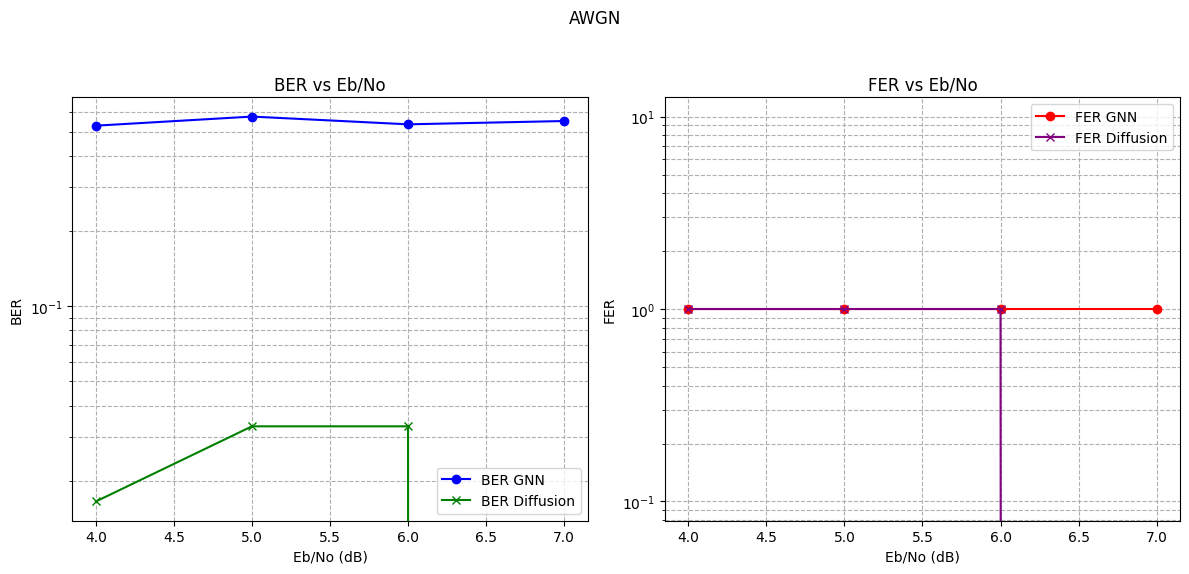

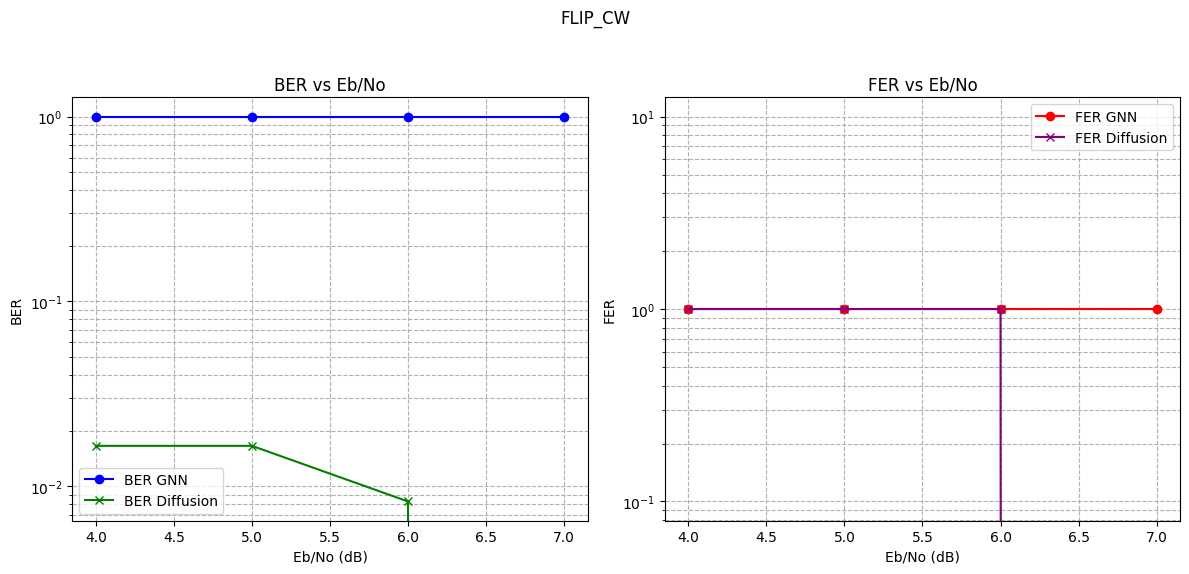

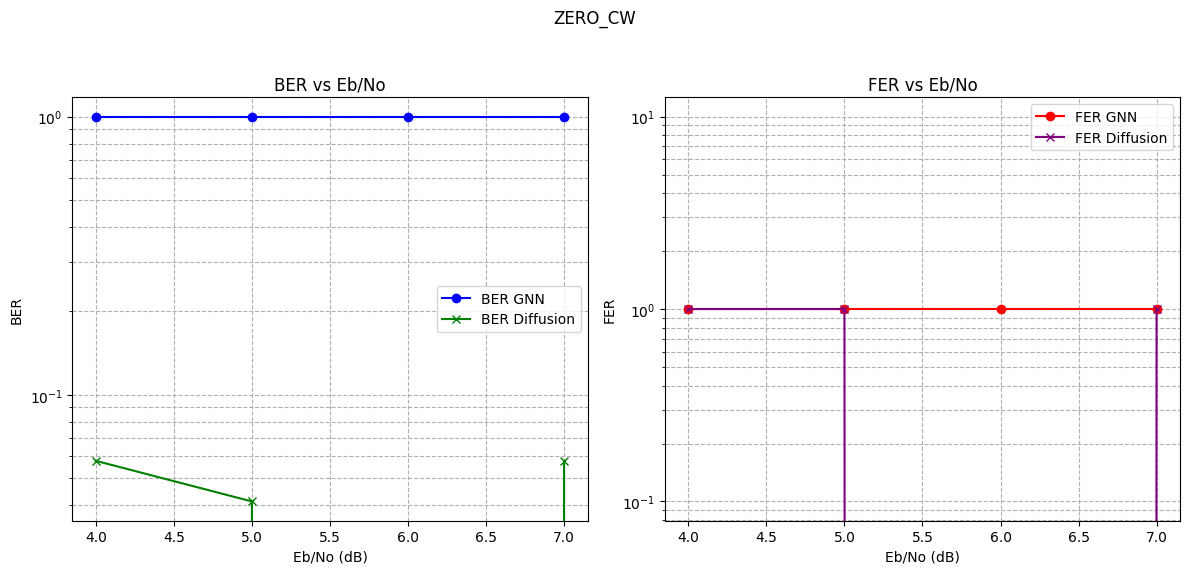

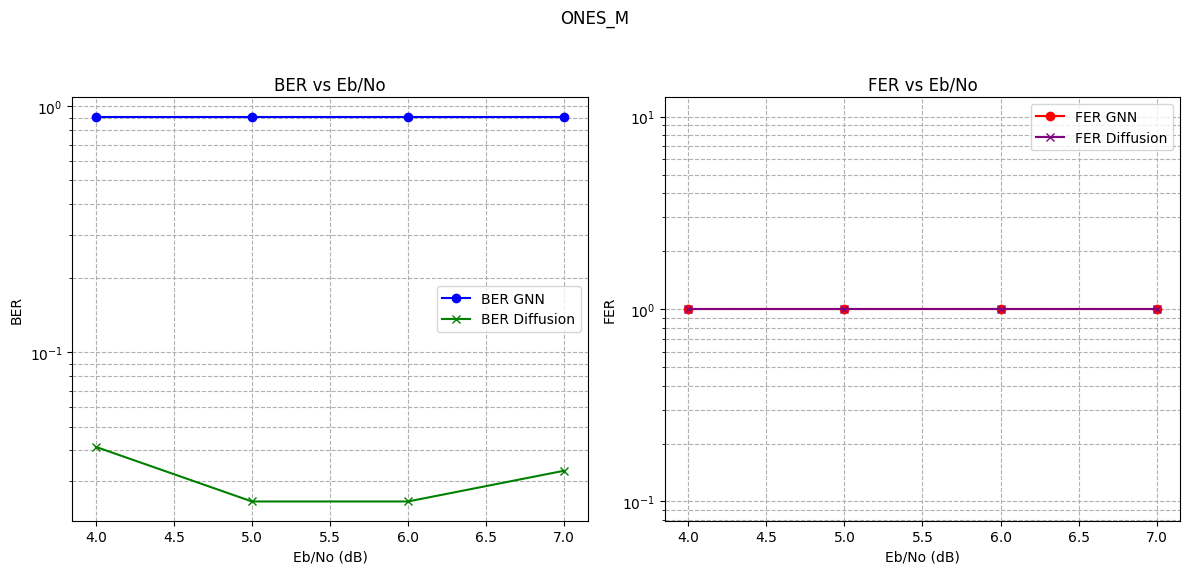

In [108]:
import matplotlib.pyplot as plt

if EbNo_range_test is None: # check if bers havent been computed
  EbNo_range_test = [4, 5, 6]

  ber_gnn = [1.89e-01, 1.55e-01, 1.24e-01]
  fer_gnn = [1.00e+00, 1.00e+00, 1.00e+00]

  ber_dif = [4.99e-02, 3.58e-02, 2.37e-02]
  fer_dif = [9.84e-01, 9.05e-01, 7.23e-01]


def plot_comparison(title, EbNo_range, ber_gnn, fer_gnn, ber_dif, fer_dif):
    plt.figure(figsize=(12, 6))

    # Plot BER for both models
    plt.subplot(1, 2, 1)
    plt.plot(EbNo_range, ber_gnn, marker='o', label='BER GNN', color='blue')
    plt.plot(EbNo_range, ber_dif, marker='x', label='BER Diffusion', color='green')
    plt.yscale('log')
    plt.xlabel('Eb/No (dB)')
    plt.ylabel('BER')
    plt.title('BER vs Eb/No')
    plt.grid(True, which="both", ls="--")
    plt.legend()

    # Plot FER for both models
    plt.subplot(1, 2, 2)
    plt.plot(EbNo_range, fer_gnn, marker='o', label='FER GNN', color='red')
    plt.plot(EbNo_range, fer_dif, marker='x', label='FER Diffusion', color='purple')
    plt.yscale('log')
    plt.xlabel('Eb/No (dB)')
    plt.ylabel('FER')
    plt.title('FER vs Eb/No')
    plt.grid(True, which="both", ls="--")
    plt.legend()

    # Set the overall title for the figure
    plt.suptitle(title)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# def remove_zeros_and_prune(*lists):
#     # Remove 0.0 values
#     lists = [[value for value in lst if value != 0.0] for lst in lists]
#     # Find the shortest list length
#     min_length = min(len(lst) for lst in lists)
#     # Prune lists to the shortest length
#     return [lst[:min_length] for lst in lists]


for ix, dataset_type in enumerate(dataset_types.keys()):
    ber_dif = data["DDECCT"][ix]['ber']
    fer_dif = data["DDECCT"][ix]['fer']

    ber_gnn = data["GNN"][ix]['ber']
    fer_gnn = data["GNN"][ix]['fer']

    # # Remove 0.0 values and prune lists to the same length
    # ber_gnn, ber_dif = remove_zeros_and_prune(ber_gnn, ber_dif)
    # fer_gnn, fer_dif = remove_zeros_and_prune(fer_gnn, fer_dif)
    # print(ber_dif, ber_dif)

    # Plot the comparison
    plot_comparison(dataset_type.upper(), EbNo_range_test, ber_gnn, fer_gnn, ber_dif, fer_dif)